In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import yaml
import subprocess
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap

Dir = '/n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/'
supDir = f"{Dir}supportData/"
figDir = Dir + 'figure/'

# sys.path.append(Dir + 'imi-gchp-local')
sys.path.append(Dir + 'code')
from make_state_vector_file import(
    make_state_vector_file,
)
from generate_grid import(
    get_gridspec_prefix,
    generate_grid_from_gridspec,
)

In [3]:
def wrap180(lon):
    lon = (lon + 180.0) % 360.0 - 180.0
    # break lines that jump across the dateline
    jumps = np.where(np.abs(np.diff(lon)) > 180)[0]
    if jumps.size:
        lon = lon.astype(float)
        lon[jumps+1] = np.nan
    return lon

def face_outline(lonb_face, latb_face):
    """
    lonb_face, latb_face: (ny+1, nx+1) arrays of corner longitudes/latitudes (degrees)
    Returns 1D arrays (L,) for the closed outline order.
    """
    ny1, nx1 = lonb_face.shape
    ny, nx = ny1-1, nx1-1

    south  = [(0, i)     for i in range(0, nx+1)]
    east   = [(j, nx)    for j in range(1, ny+1)]
    north  = [(ny, i)    for i in range(nx-1, -1, -1)]
    west   = [(j, 0)     for j in range(ny-1, 0, -1)]
    idx = south + east + north + west

    lon = np.array([lonb_face[j, i] for (j, i) in idx], dtype=float)
    lat = np.array([latb_face[j, i] for (j, i) in idx], dtype=float)
    lon = wrap180(lon)
    return lon, lat

In [4]:
def create_regrid_weights(CS_RES, STRETCH_GRID, STRETCH_FACTOR, TARGET_LAT, TARGET_LON):
    prefix = get_gridspec_prefix(CS_RES, STRETCH_GRID, STRETCH_FACTOR, TARGET_LAT, TARGET_LON)
    # print(prefix)
    if not os.path.exists(os.path.join(supDir, f"{prefix}_gridspec.nc")):
        subprocess.run([
            'gridspec-create', 'sgcs',
            '-s', f"{STRETCH_FACTOR}",
            '-t', f"{TARGET_LAT}", f"{TARGET_LON}", f"{CS_RES}"
            ],
            check=True, cwd=supDir,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,)

    if not os.path.exists(os.path.join(supDir, f"{prefix}_formatted.nc")):
        gridds = generate_grid_from_gridspec(CS_RES, f"{supDir}{prefix}_formatted.nc", True, 
                                        STRETCH_FACTOR, TARGET_LAT, TARGET_LON, 
                                        workdir=supDir, prefix=prefix)

    nativeres = "0.25x0.3125"
    src_grid_path = f"regular_lat_lon_721x1152.nc"
    dst_grid_path = f"{prefix}_gridspec.nc"

    regrid_weight_fpath = f"regrid_weights_{nativeres}_to_c{CS_RES}_s{STRETCH_FACTOR:.1f}_{TARGET_LAT:.1f}N_{TARGET_LON:.1f}E_conserve.nc"
    if not os.path.exists(os.path.join(supDir, regrid_weight_fpath)):
        subprocess.run([
            "ESMF_RegridWeightGen",
            "-s", src_grid_path,
            "-d", dst_grid_path,
            "-m", "conserve",
            "--ignore_unmapped",
            "-w", regrid_weight_fpath
            ], 
            check=True, cwd=supDir, 
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL, 
        )

In [5]:
def get_statevector_gchp(sv_gchp_fpath, face_id=None):
    """
    Extract state vector polygons and values from a GCHP cubed-sphere restart.

    Parameters
    ----------
    sv_gchp_fpath : str
        Path to the state vector NetCDF file.
    face_id : int or None, optional
        Face index (0–5). If None, process all 6 faces.

    Returns
    -------
    valid_corners : ndarray
        Array of polygon corners [ncell, 5, 2] (lon, lat).
    valid_sv : ndarray
        State vector values for each cell.
    """
    sv_gchp_ds = xr.open_dataset(sv_gchp_fpath).squeeze()
    sv_gchp = sv_gchp_ds['StateVector'].values
    sv_mask_gchp = sv_gchp <= np.nanmax(sv_gchp)

    corner_lons = sv_gchp_ds['corner_lons'].values
    corner_lats = sv_gchp_ds['corner_lats'].values
    res = len(sv_gchp_ds.Xdim)

    def process_face(face):
        c = np.stack((corner_lons[face], corner_lats[face]), axis=-1)
        # 5-point polygons
        face_corners = np.stack([
            c[:-1, :-1],
            c[1:, :-1],
            c[1:, 1:],
            c[:-1, 1:],
            c[:-1, :-1]
        ], axis=2)
        face_corners = face_corners.reshape((res * res, 5, 2))
        return face_corners.tolist(), sv_gchp[face].ravel()

    if face_id is not None:  # just one face
        corners, values = process_face(face_id)
        mask = sv_mask_gchp[face_id].ravel()
        return np.array(corners)[mask], values[mask]

    # otherwise do all faces
    all_corners, all_values = [], []
    for face in range(6):
        corners, values = process_face(face)
        all_corners.append(corners)
        all_values.append(values)

    all_corners = np.concatenate(all_corners)
    all_values = np.concatenate(all_values)

    mask = sv_mask_gchp.ravel()
    return all_corners[mask], all_values[mask]


In [6]:
config_fpath = Dir + 'code/config-soil-c36s10-1month.yml'
config = yaml.load(open(config_fpath), Loader=yaml.FullLoader)

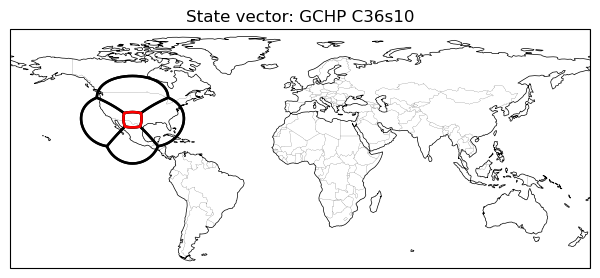

In [6]:
# test
sv_fpath = '/n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/\
output-gchp-stretch-soil/Test_Stretch_1month/StateVector.nc'
sv_ds = xr.open_dataset(sv_fpath).squeeze()
corner_lons = sv_ds['corner_lons'].values
corner_lats = sv_ds['corner_lats'].values

extents = [-180,180,-60,88]
res = '36s10'
aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
proj = ccrs.PlateCarree()
trans = ccrs.Geodetic()

totwidth = 6.5
nrows, ncols = 1, 1
subwidth = totwidth / ncols
subheight = subwidth / aspect
totheight = subheight * nrows

fig, ax = plt.subplots(
    nrows, ncols,
    figsize=(totwidth, totheight),
    subplot_kw={'projection': proj},
    constrained_layout=True
)

axtitle = f'State vector: GCHP C{res}'
ax.set_title(axtitle)
ax.set_extent(extents, crs=proj)
ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '110m', \
    edgecolor='black', facecolor='none', linewidth=.5))
ax.add_feature(cfeat.BORDERS, linewidth=.1)
for f in range(6):
    lon, lat = face_outline(corner_lons[f], corner_lats[f])
    ax.plot(lon, lat, transform=ccrs.PlateCarree(), lw=1.8, color='k')
for f in [5]:
    lon, lat = face_outline(corner_lons[f], corner_lats[f])
    ax.plot(lon, lat, transform=ccrs.PlateCarree(), lw=1.8, color='red')


In [7]:
CS_RES = config['CS_RES']
STRETCH_GRID = config['STRETCH_GRID']
STRETCH_FACTOR=config['STRETCH_FACTOR']

land_cover_pth="/n/holylfs06/LABS/jacob_lab/Shared/GEOS-CHEM/gcgrid/gcdata/\
ExtData/GEOS_0.25x0.3125/GEOS_FP/2011/01/GEOSFP.20110101.CN.025x03125.nc"
hemco_diag_pth="/n/holylfs06/LABS/jacob_lab/Shared/GEOS-CHEM/gcgrid/gcdata/\
ExtData/HEMCO/CH4/v2025-07/HEMCO_SA_Output/HEMCO_sa_diagnostics.025x03125.2023.nc"


In [11]:
TARGET_LAT = 32.
TARGET_LON = -104.

create_regrid_weights(CS_RES, STRETCH_GRID, STRETCH_FACTOR, TARGET_LAT, TARGET_LON)

In [12]:
# generate the state vector dataset
CSgridDir = supDir
save_pth = f"{supDir}StateVector_c{CS_RES}_s{STRETCH_FACTOR:.1f}_{TARGET_LAT:.1f}N_{TARGET_LON:.1f}E.nc"
sv_ds = make_state_vector_file(
    config,
    TARGET_LAT,
    TARGET_LON,
    CSgridDir,
    land_cover_pth,
    hemco_diag_pth,
    save_pth,
).squeeze()

Saving file /n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/supportData/StateVector_c36_s10.0_32.0N_-104.0E.nc


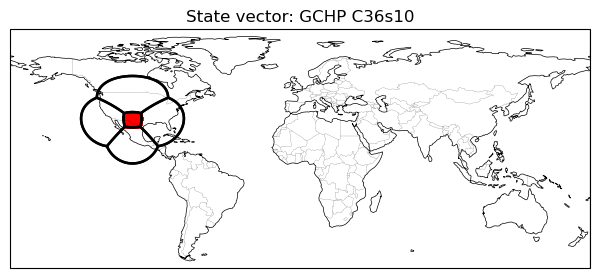

In [13]:
# plot
extents = [-180,180,-60,88]
res = '36s10'
aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
proj = ccrs.PlateCarree()
trans = ccrs.Geodetic()

totwidth = 6.5
nrows, ncols = 1, 1
subwidth = totwidth / ncols
subheight = subwidth / aspect
totheight = subheight * nrows

fig, ax = plt.subplots(
    nrows, ncols,
    figsize=(totwidth, totheight),
    subplot_kw={'projection': proj},
    constrained_layout=True
)

axtitle = f'State vector: GCHP C{res}'
ax.set_title(axtitle)
ax.set_extent(extents, crs=proj)
ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '110m', \
    edgecolor='black', facecolor='none', linewidth=.5))
ax.add_feature(cfeat.BORDERS, linewidth=.1)

corner_lons = sv_ds['corner_lons'].values
corner_lats = sv_ds['corner_lats'].values

for f in range(6):
    lon, lat = face_outline(corner_lons[f], corner_lats[f])
    ax.plot(lon, lat, transform=ccrs.PlateCarree(), lw=1.8, color='k')
    
    sv_label = sv_ds['StateVector'][f]
    mask = sv_label <= 0
    sv_masked = np.ma.masked_array(np.ones_like(sv_label), mask=mask)
for f in [5]:
    pcm = ax.pcolormesh(
        corner_lons[f], corner_lats[f], sv_masked,
        color="red", facecolors="red", edgecolors="none",shading='auto'
    )

/n/jacob_lab/Users/dzhang8/mamba/envs/imi-gchp/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/n/jacob_lab/Users/dzhang8/mamba/envs/imi-gchp/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


Plot saved to /n/holylfs06/LABS/jacob_lab2/Lab/dzhang8/imi-gchp-test/figure/Tiling_target_faces.png


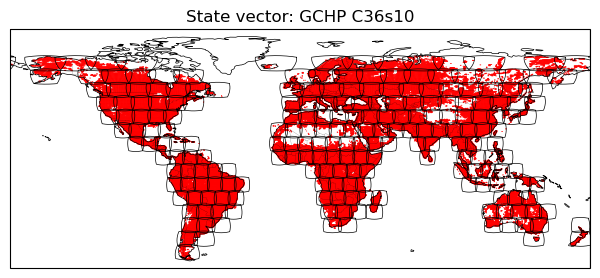

In [8]:
# read csv containing the target coords
coord_fpath = supDir + 'target_coords.csv'
coord_df = pd.read_csv(coord_fpath)
# target coords are only 1 digits in original
target_lats = coord_df['Target_lat'].values
target_lons = coord_df['Target_lon'].values

extents = [-180,180,-60,88]
res = '36s10'
aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
proj = ccrs.PlateCarree()
trans = ccrs.Geodetic()

totwidth = 6.5
nrows, ncols = 1, 1
subwidth = totwidth / ncols
subheight = subwidth / aspect
totheight = subheight * nrows

fig, ax = plt.subplots(
    nrows, ncols,
    figsize=(totwidth, totheight),
    subplot_kw={'projection': proj},
    constrained_layout=True
)

axtitle = f'State vector: GCHP C{res}'
ax.set_title(axtitle)
ax.set_extent(extents, crs=proj)
ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '110m', \
    edgecolor='black', facecolor='none', linewidth=.5))
ax.add_feature(cfeat.BORDERS, linewidth=.1)

num_sv = []
for ti in range(len(target_lats)):
    TARGET_LAT = target_lats[ti]
    TARGET_LON = round(((target_lons[ti]) + 180) % 360 - 180, 1)
    
    create_regrid_weights(CS_RES, STRETCH_GRID, STRETCH_FACTOR, TARGET_LAT, TARGET_LON)
    CSgridDir = supDir
    save_pth = f"{supDir}StateVector_c{CS_RES}_s{STRETCH_FACTOR:.1f}_{TARGET_LAT:.1f}N_{TARGET_LON:.1f}E.nc"
    if not os.path.exists(save_pth):
        sv_ds = make_state_vector_file(
            config,
            TARGET_LAT,
            TARGET_LON,
            CSgridDir,
            land_cover_pth,
            hemco_diag_pth,
            save_pth,
        ).squeeze()
    else:
        sv_ds = xr.open_dataset(save_pth).squeeze()
    corner_lons = sv_ds['corner_lons'].values
    corner_lats = sv_ds['corner_lats'].values
    valid_corners_gchp, valid_sv_gchp = get_statevector_gchp(save_pth, face_id=5)
    
    coll = PolyCollection(
        valid_corners_gchp, lw=0.3, edgecolors='red',facecolors='none',
        transform=trans,
    )
    ax.add_collection(coll)
    
    num_sv.append(valid_sv_gchp.shape[0])
    
    for f in [5]:
        lon, lat = face_outline(corner_lons[f], corner_lats[f])
        ax.plot(lon, lat, transform=ccrs.PlateCarree(), lw=.5, color='k')
        
figfpath = figDir + 'Tiling_target_faces.png'
fig.savefig(figfpath, format="png", bbox_inches="tight", dpi=300)
print(f"Plot saved to {figfpath}")
# plt.close()
fpath = supDir + 'target_coords_num-sv.csv'
coord_df['num_sv'] = num_sv
coord_df.to_csv(fpath, sep=',', index=False)

In [52]:
fpath = supDir + 'target_coords_num-sv.csv'
coord_df = pd.read_csv(fpath)
num_sv = coord_df['num_sv'].values
print(f'Total number of state vector elements: {np.sum(np.array(num_sv))}')
print(f'Number of target faces: {len(target_lats)}')
print(f'Min number of state vector elements: {np.nanmin(np.array(num_sv))}')
print(f'Max number of state vector elements: {np.nanmax(np.array(num_sv))}')

Total number of state vector elements: 168862
Number of target faces: 220
Min number of state vector elements: 47
Max number of state vector elements: 1296


In [15]:
# Combine all state vectors
sv_ds_all = []
for ti in range(len(target_lats)):
    TARGET_LAT = target_lats[ti]
    TARGET_LON = round(((target_lons[ti]) + 180) % 360 - 180, 1)
    sv_fpath = f"{supDir}StateVector_c{CS_RES}_s{STRETCH_FACTOR:.1f}_{TARGET_LAT:.1f}N_{TARGET_LON:.1f}E.nc"
    sv_ds = xr.open_dataset(sv_fpath, mask_and_scale=False)
    sv_ds_all.append(sv_ds)
combined_ds = xr.concat(sv_ds_all, dim="target_face")
combined_ds['StateVector'] = combined_ds['StateVector'].transpose('time', 'target_face', 'nf', 'Ydim', 'Xdim')
combined_ds['TARGET_LAT'] = xr.DataArray(target_lats, dims=["target_face"], 
                                         attrs=dict(long_name='Target latitude',
                                                    units='degree_north'))
combined_ds['TARGET_LON'] = xr.DataArray(target_lats, dims=["target_face"], 
                                         attrs=dict(long_name='Target longitude',
                                                    units='degree_east'))
# add global attribites
combined_ds.attrs = {'CS_RES': CS_RES, 'STRETCH_FACTOR': STRETCH_FACTOR}
save_pth = f'{supDir}StateVector_c{CS_RES}_s{STRETCH_FACTOR:.1f}_combined.nc'
combined_ds.to_netcdf(
            save_pth,
            encoding={
                v: {"zlib": True, "complevel": 1} for v in combined_ds.data_vars
            },
        )

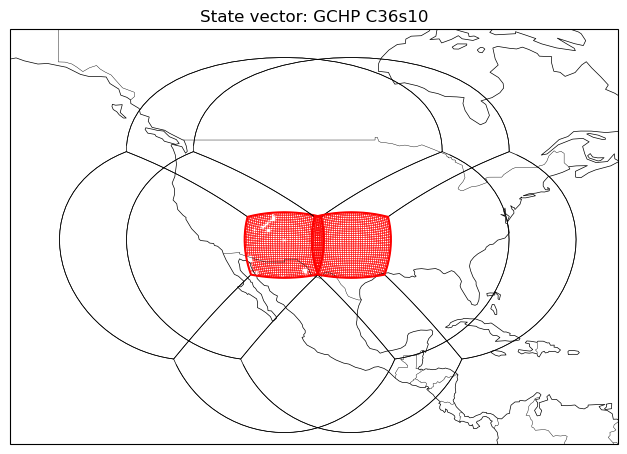

In [36]:
# read csv containing the target coords
coord_fpath = supDir + 'target_coords.csv'
coord_df = pd.read_csv(coord_fpath)
target_lats = np.round(coord_df['Target_lat'].values.astype(float), 1)
target_lons = np.round(coord_df['Target_lon'].values.astype(float), 1)

extents = [-148,-60,5,65]
# extents = [-180,180,-60,70]
res = '36s10'
aspect = (extents[1] - extents[0]) / (extents[3] - extents[2])
proj = ccrs.PlateCarree()
trans = ccrs.Geodetic()

totwidth = 6.5
nrows, ncols = 1, 1
subwidth = totwidth / ncols
subheight = subwidth / aspect
totheight = subheight * nrows

fig, ax = plt.subplots(
    nrows, ncols,
    figsize=(totwidth, totheight),
    subplot_kw={'projection': proj},
    constrained_layout=True
)

axtitle = f'State vector: GCHP C{res}'
ax.set_title(axtitle)
ax.set_extent(extents, crs=proj)
ax.add_feature(cfeat.NaturalEarthFeature('physical', 'ocean', '110m', \
    edgecolor='black', facecolor='none', linewidth=.5))
ax.add_feature(cfeat.BORDERS, linewidth=.3)

for ti in range(73,75):
    TARGET_LAT = target_lats[ti]
    TARGET_LON = ((float(target_lons[ti]) + 180) % 360) - 180
    
    create_regrid_weights(CS_RES, STRETCH_GRID, STRETCH_FACTOR, TARGET_LAT, TARGET_LON)
    CSgridDir = supDir
    save_pth = f"{supDir}StateVector_c{CS_RES}_s{STRETCH_FACTOR:.1f}_{TARGET_LAT:.1f}N_{TARGET_LON:.1f}E.nc"
    if not os.path.exists(save_pth):
        sv_ds = make_state_vector_file(
            config,
            TARGET_LAT,
            TARGET_LON,
            CSgridDir,
            land_cover_pth,
            hemco_diag_pth,
            save_pth,
        ).squeeze()
    else:
        sv_ds = xr.open_dataset(save_pth).squeeze()
    corner_lons = sv_ds['corner_lons'].values
    corner_lats = sv_ds['corner_lats'].values
    valid_corners_gchp, valid_sv_gchp = get_statevector_gchp(save_pth, face_id=5)
    
    coll = PolyCollection(
        valid_corners_gchp, lw=0.3, edgecolors='red',facecolors='none',
        transform=trans,
    )
    ax.add_collection(coll)
    
    for f in range(6):
        lon, lat = face_outline(corner_lons[f], corner_lats[f])
        if f==5:
            ax.plot(lon, lat, transform=ccrs.PlateCarree(), lw=1.5, color='red')
        else:
            ax.plot(lon, lat, transform=ccrs.PlateCarree(), lw=.5, color='k')
        
# figfpath = figDir + 'Tiling_target_faces.png'
# fig.savefig(figfpath, format="png", bbox_inches="tight", dpi=300)
# print(f"Plot saved to {figfpath}")
# plt.close()
# fpath = supDir + 'target_coords_num-sv.csv'
# coord_df['num_sv'] = num_sv
# coord_df.to_csv(fpath, index=False)